# Overview
The goal of this assignment is to predict category for the given Twitter post. The categories can be: __(A) Political (B) Finance (C) Journal__. The dataset was small (just around 500 example) and the data within it was skewed, which greatly impacted on the difficulty of building good classifier. After creating a lot of custom features, using _bag-of-words_ and applying the logistic regression, the classification accuracy at level of 51% was achieved.

# 1. Getting Data from Twitter API
I will be using a Python library call `Tweepy` to connect to Twitter API and downloading the data.

In [1]:
import tweepy
import json
import numpy as np
import pandas as pd
from tweepy import OAuthHandler
from tweepy import API
from tweepy import Cursor
from datetime import datetime, date, time, timedelta
from collections import Counter
import sys

In [2]:
consumer_key = 'ZKlfP6lgUIVSl6QAzXNvRyqfs'
consumer_secret = '7LBH2g8Hk05Sxa6rqnB27Aq2viaqEdMuf3fDLBEH4JSECbAVEy'

In [3]:
# Consumer key authentication
auth = OAuthHandler(consumer_key, consumer_secret)

In [4]:
access_token = '1042808210149715969-9XmzvVeFRvtkQZW8cVXbEMFsbZm3m0'
access_token_secret = 'Afkg5xl3AQa5fN0JoWFDVXtQf1GkC220Lkjt9HLOn3BR6'

In [5]:
# Access key authentication
auth.set_access_token(access_token, access_token_secret)

In [6]:
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

The `test.csv` inclued a set of 500 Twitter user IDs

In [7]:
test = pd.read_csv('test.csv')
test.head()

,Twitter Id,Category
0,4912945864,Politician
1,1900694785,Politician
2,1887255132,Politician
3,1873380343,Politician
4,1872999342,Politician


In [8]:
id_list = test['Twitter Id'].tolist() # Convert to list

Because `tweepy` does not support to get more than 100 users at time. Therefore, I will write the function that can get the tweets of more than 100 users

In [9]:
def lookup_user_list(followers_id, api):
    full_users = []
    users_count = len(followers_id)
    while True:
        try:
            for i in range(int(users_count / 100) + 1):
                full_users.extend(api.lookup_users(user_ids=followers_id[i*100:min((i+1)*100, users_count)]))
                print('getting users batch:', i)
        except tweepy.TweepError as e:
            print('Something went wrong, quitting...', e)
            time.sleep(15 * 60)
        return full_users

Apply function

In [10]:
results = lookup_user_list(id_list, api) 

getting users batch: 0
getting users batch: 1
getting users batch: 2
getting users batch: 3
getting users batch: 4
getting users batch: 5


Wrangle the data into one dataframe

In [11]:
# Create JSON
js = json.dumps([status._json for status in results]) 

users = pd.read_json(js, orient='records')

In [12]:
users_full = pd.merge(test, users, left_on='Twitter Id', right_on='id', how='left').drop('id', axis=1)

Let's look at our new dataframe `users_full`

In [13]:
users_full.head()

,Twitter Id,Category,contributors_enabled,created_at,default_profile,default_profile_image,description,entities,favourites_count,follow_request_sent,...,profile_use_background_image,protected,screen_name,status,statuses_count,time_zone,translator_type,url,utc_offset,verified
0,4912945864,Politician,False,2016-02-15 10:23:32,False,False,District Councillor for SODC Chinnor Ward with...,{'description': {'urls': []}},18643.0,False,...,True,False,IanWhite_DC,{'created_at': 'Wed Sep 26 17:41:00 +0000 2018...,12991.0,NaN,none,None,NaN,False
1,1900694785,Politician,False,2013-09-24 14:29:28,False,False,ケネディ前大使のアーカイブアカウント。アメリカ大使館のニュースは@USEmbassyToky...,{'url': {'urls': [{'url': 'https://t.co/hED6j9...,344.0,False,...,False,False,AmbCKennedy,{'created_at': 'Wed Jan 18 12:02:53 +0000 2017...,979.0,NaN,none,https://t.co/hED6j945kN,NaN,True
2,1887255132,Politician,False,2013-09-20 17:48:12,True,False,"My tweets and views are my own. Philadelphia, PA.",{'url': {'urls': [{'url': 'https://t.co/FudBly...,125.0,False,...,True,False,grustia_aarp,{'created_at': 'Sun Sep 16 12:08:47 +0000 2018...,251.0,NaN,none,https://t.co/FudBly9U3r,NaN,False
3,1873380343,Politician,False,2013-09-16 23:20:09,False,False,"Owner, Faye's Fabulous Flowers",{'url': {'urls': [{'url': 'https://t.co/I3gYTJ...,165.0,False,...,True,False,drfayenaples,{'created_at': 'Fri Jul 27 00:45:10 +0000 2018...,199.0,NaN,none,https://t.co/I3gYTJmraD,NaN,False
4,1872999342,Politician,False,2013-09-16 21:08:18,False,False,"Campaign account for Senator Chuck Schumer, D-...",{'url': {'urls': [{'url': 'http://t.co/BooKG20...,7.0,False,...,True,False,chuckschumer,{'created_at': 'Tue Dec 19 22:17:23 +0000 2017...,378.0,NaN,none,http://t.co/BooKG20lX6,NaN,True


In [14]:
users_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 556 entries, 0 to 555
Data columns (total 44 columns):
Twitter Id                            556 non-null int64
Category                              556 non-null object
contributors_enabled                  515 non-null object
created_at                            515 non-null datetime64[ns]
default_profile                       515 non-null object
default_profile_image                 515 non-null object
description                           515 non-null object
entities                              515 non-null object
favourites_count                      515 non-null float64
follow_request_sent                   515 non-null object
followers_count                       515 non-null float64
following                             515 non-null object
friends_count                         515 non-null float64
geo_enabled                           515 non-null object
has_extended_profile                  515 non-null object
id_str         

In [15]:
users_full['status'][0]

{'created_at': 'Wed Sep 26 17:41:00 +0000 2018',
 'id': 1045005329950543873,
 'id_str': '1045005329950543873',
 'text': 'SODC Planning Committee tonight at Didcot Civic Hall. Some interesting cases on the agenda including Wyevale at Hen… https://t.co/orVajyM0Jx',
 'truncated': True,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [{'url': 'https://t.co/orVajyM0Jx',
    'expanded_url': 'https://twitter.com/i/web/status/1045005329950543873',
    'display_url': 'twitter.com/i/web/status/1…',
    'indices': [117, 140]}]},
 'source': '<a href="https://buffer.com" rel="nofollow">Buffer</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'geo': None,
 'coordinates': None,
 'place': None,
 'contributors': None,
 'is_quote_status': False,
 'retweet_count': 1,
 'favorite_count': 1,
 'favorited': False,
 'retweeted': False,
 'lang': 'en'}

There are lots of information we can get but for purpose of this assignment, I just want to collect the recent tweet from each of users.

In [16]:
data = users_full[['Twitter Id','Category','status']]

In [17]:
data.head()

,Twitter Id,Category,status
0,4912945864,Politician,{'created_at': 'Wed Sep 26 17:41:00 +0000 2018...
1,1900694785,Politician,{'created_at': 'Wed Jan 18 12:02:53 +0000 2017...
2,1887255132,Politician,{'created_at': 'Sun Sep 16 12:08:47 +0000 2018...
3,1873380343,Politician,{'created_at': 'Fri Jul 27 00:45:10 +0000 2018...
4,1872999342,Politician,{'created_at': 'Tue Dec 19 22:17:23 +0000 2017...


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 556 entries, 0 to 555
Data columns (total 3 columns):
Twitter Id    556 non-null int64
Category      556 non-null object
status        481 non-null object
dtypes: int64(1), object(2)
memory usage: 37.4+ KB


Remove some missing values in the `status` column.

In [19]:
data = data[pd.notnull(data['status'])]
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 3 columns):
Twitter Id    481 non-null int64
Category      481 non-null object
status        481 non-null object
dtypes: int64(1), object(2)
memory usage: 11.4+ KB


In [20]:
data['tweets'] = [data['status'][i].get('text') for i in range(0,len(data))]
data = data.drop('status', axis=1)
data.head()

,Twitter Id,Category,tweets
0,4912945864,Politician,SODC Planning Committee tonight at Didcot Civi...
1,1900694785,Politician,今まで本当にありがとうございました。今後は@USEmbassyTokyoをフォローしてくださ...
2,1887255132,Politician,@MrRawle Well deserved. Congratulations!!!
3,1873380343,Politician,2 people unfollowed me // automatically checke...
4,1872999342,Politician,RT @lilybatch: New estimates: Final tax plan w...


Save the `data` to the `data.csv` file.

In [21]:
data.to_csv('data.csv', index=False)

# 2. Data preprocessing
In this step I will do cleansing: remove URLs, usernames(mentions), tweets not available text, hashtag, numbers, special characters; text processing: tokenize, transform to lowercase.

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from collections import Counter
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
import re 
import gensim
import warnings
warnings.filterwarnings('ignore')
sns.set()

C:\Users\Augustine\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Defining data cleaning function

In [23]:
tok = WordPunctTokenizer()

pat1 = r'RT @[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

Apply `tweet_cleaner` function

In [24]:
tweets_list = data.tweets.tolist()
results = []
for t in tweets_list:
    results.append(tweet_cleaner(t))

In [25]:
clean_data = pd.DataFrame(results,columns=['tweet'])
clean_data['category'] = data['Category']
clean_data['id'] = data['Twitter Id']
clean_data.head()

,tweet,category,id
0,sodc planning committee tonight at didcot civi...,Politician,4912945864
1,usembassytokyo imamade hontoni arigato gozaima...,Politician,1900694785
2,mrrawle well deserved congratulations,Politician,1887255132
3,people unfollowed me automatically checked by,Politician,1873380343
4,new estimates final tax plan would raise taxes...,Politician,1872999342


In [26]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 3 columns):
tweet       481 non-null object
category    481 non-null object
id          481 non-null int64
dtypes: int64(1), object(2)
memory usage: 11.4+ KB


In [27]:
clean_data.to_csv('clean_data.csv', index=False, encoding='utf-8')

# 3. Exploratory data analysis (EDA)
Before do data visualization, I want to known that what kind of words are used in the tweets, and how many times it is used in entire corpus. I used count vectorizer to calculate the term frequencies.
There are parameter options available for count vectorizer, such as removing stop words, limiting the maximum number of terms. However, I just implemented with stop words included, and not limiting the maximum number of terms.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
data = clean_data.copy()
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 3 columns):
tweet       481 non-null object
category    481 non-null object
id          481 non-null int64
dtypes: int64(1), object(2)
memory usage: 11.4+ KB


In [31]:
cvec = CountVectorizer()
cvec.fit(data.tweet)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [32]:
len(cvec.get_feature_names()) # 2931 words out of the corpus

2907

In [33]:
data.category.value_counts()

Journalist    224
Trader        144
Politician    113
Name: category, dtype: int64

Getting term frequency for each class can be obtained with the below code block.

In [34]:
journalist_doc_matrix = cvec.transform(data[data.category == 'Journalist'].tweet)
trader_doc_matrix = cvec.transform(data[data.category == 'Trader'].tweet)
politician_doc_matrix = cvec.transform(data[data.category == 'Politician'].tweet)

journalist_tf = np.sum(journalist_doc_matrix,axis=0)
trader_tf = np.sum(trader_doc_matrix,axis=0)
politician_tf = np.sum(politician_doc_matrix,axis=0)

journalist = np.squeeze(np.asarray(journalist_tf))
trader = np.squeeze(np.asarray(trader_tf))
politician =  np.squeeze(np.asarray(politician_tf))

term_freq_df = pd.DataFrame([journalist,trader,politician],columns=cvec.get_feature_names()).transpose()

In [35]:
document_matrix = cvec.transform(data.tweet)

In [36]:
data[data.category == 'Politician'].tail()

,tweet,category,id
108,should charges have been laid,Politician,122487895
109,social media can be useful tool for communicat...,Politician,121484113
110,reverse conference bounce for lab in any case ...,Politician,121127090
111,trump signs billion bill to give vets more hea...,Politician,120334688
112,this this is all you need to know after years ...,Politician,118429508


In [37]:
%%time
politician_batches = np.linspace(0,113,100).astype(int)
i=0
politician_tf = []
while i < len(politician_batches)-1:
    batch_result = np.sum(document_matrix[politician_batches[i]:politician_batches[i+1]].toarray(),axis=0)
    politician_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(politician_batches)-2):
        print(politician_batches[i+1],"entries' term freuquency calculated")
    i += 1

1 entries' term freuquency calculated
12 entries' term freuquency calculated
23 entries' term freuquency calculated
35 entries' term freuquency calculated
46 entries' term freuquency calculated
58 entries' term freuquency calculated
69 entries' term freuquency calculated
81 entries' term freuquency calculated
92 entries' term freuquency calculated
103 entries' term freuquency calculated
113 entries' term freuquency calculated
Wall time: 31.2 ms


In [38]:
data[data.category == 'Trader'].head()

,tweet,category,id
113,laminine stardnienie rozsiane sm,Trader,1898394962
114,sorry for not being online guys ll be back in ...,Trader,1895120856
115,eminiplayer mac book air,Trader,1893573728
116,get free demo account when you register with g...,Trader,1885693524
117,ahahha this sounds optimistic meanwhile the ja...,Trader,1885361696


In [39]:
data[data.category == 'Trader'].tail()

,tweet,category,id
252,mini futures trading community at over new use...,Trader,120317534
253,my lovely girl is doing moonwalk this weekend ...,Trader,119391979
254,dec contract,Trader,118133820
255,bearish picks for axp fslr gas gild lltc nsm p...,Trader,118042818
256,,Trader,117657763


In [40]:
%%time
trader_batches = np.linspace(113,257,100).astype(int)
i=0
trader_tf = []
while i < len(trader_batches)-1:
    batch_result = np.sum(document_matrix[trader_batches[i]:trader_batches[i+1]].toarray(),axis=0)
    trader_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(trader_batches)-2):
        print(trader_batches[i+1],"entries' term freuquency calculated")
    i += 1

114 entries' term freuquency calculated
129 entries' term freuquency calculated
143 entries' term freuquency calculated
158 entries' term freuquency calculated
172 entries' term freuquency calculated
187 entries' term freuquency calculated
201 entries' term freuquency calculated
216 entries' term freuquency calculated
230 entries' term freuquency calculated
245 entries' term freuquency calculated
257 entries' term freuquency calculated
Wall time: 19.4 ms


In [41]:
data[data.category == 'Journalist'].tail()

,tweet,category,id
476,colleen ham thank you so much,Journalist,4872732821
477,judge dismissed the murder charge against keit...,Journalist,4872357934
478,thanks to davenewbart for indulging me today a...,Journalist,4872354465
479,virgin media outage or service down current pr...,Journalist,4872197440
480,la fiestaca,Journalist,4872173549


In [42]:
%%time
journalist_batches = np.linspace(256,481,100).astype(int)
i=0
journalist_tf = []
while i < len(journalist_batches)-1:
    batch_result = np.sum(document_matrix[journalist_batches[i]:journalist_batches[i+1]].toarray(),axis=0)
    journalist_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(journalist_batches)-2):
        print(journalist_batches[i+1],"entries' term freuquency calculated")
    i += 1

258 entries' term freuquency calculated
281 entries' term freuquency calculated
303 entries' term freuquency calculated
326 entries' term freuquency calculated
349 entries' term freuquency calculated
371 entries' term freuquency calculated
394 entries' term freuquency calculated
417 entries' term freuquency calculated
440 entries' term freuquency calculated
462 entries' term freuquency calculated
481 entries' term freuquency calculated
Wall time: 24 ms


In [43]:
journalist = np.sum(journalist_tf,axis=0)
trader = np.sum(trader_tf,axis=0)
politician = np.sum(politician_tf,axis=0)
term_freq_df = pd.DataFrame([journalist,trader,politician],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()

,0,1,2
aaa,0,0,1
aapl,0,1,0
aaronw,0,1,0
abarth,1,0,0
abc,1,0,0


In [44]:
term_freq_df.columns = ['journalist', 'trader', 'politician']
term_freq_df['total'] = term_freq_df['journalist'] + term_freq_df['trader'] + term_freq_df['politician']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10] # Top frequent words by total

,journalist,trader,politician,total
the,89,43,62,194
to,60,30,49,139
and,38,26,36,100
of,45,14,33,92
in,38,23,20,81
you,30,18,20,68
for,26,19,19,64
on,22,13,18,53
is,23,10,8,41
this,18,9,12,39


You can see that the most frequent words are all stop words like `the`,`to`,`and`,`of`, ect. If these stop words dominate both of the classes, I won't be able to have a meaningful result. So, I decided to remove stop words.

In [45]:
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(data.tweet)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [46]:
document_matrix = cvec.transform(data.tweet)

In [47]:
%%time
politician_batches = np.linspace(0,113,100).astype(int)
i=0
politician_tf = []
while i < len(politician_batches)-1:
    batch_result = np.sum(document_matrix[politician_batches[i]:politician_batches[i+1]].toarray(),axis=0)
    politician_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(politician_batches)-2):
        print(politician_batches[i+1],"entries' term freuquency calculated")
    i += 1

1 entries' term freuquency calculated
12 entries' term freuquency calculated
23 entries' term freuquency calculated
35 entries' term freuquency calculated
46 entries' term freuquency calculated
58 entries' term freuquency calculated
69 entries' term freuquency calculated
81 entries' term freuquency calculated
92 entries' term freuquency calculated
103 entries' term freuquency calculated
113 entries' term freuquency calculated
Wall time: 40.6 ms


In [48]:
%%time
trader_batches = np.linspace(113,257,100).astype(int)
i=0
trader_tf = []
while i < len(trader_batches)-1:
    batch_result = np.sum(document_matrix[trader_batches[i]:trader_batches[i+1]].toarray(),axis=0)
    trader_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(trader_batches)-2):
        print(trader_batches[i+1],"entries' term freuquency calculated")
    i += 1

114 entries' term freuquency calculated
129 entries' term freuquency calculated
143 entries' term freuquency calculated
158 entries' term freuquency calculated
172 entries' term freuquency calculated
187 entries' term freuquency calculated
201 entries' term freuquency calculated
216 entries' term freuquency calculated
230 entries' term freuquency calculated
245 entries' term freuquency calculated
257 entries' term freuquency calculated
Wall time: 15.6 ms


In [49]:
%%time
journalist_batches = np.linspace(256,481,100).astype(int)
i=0
journalist_tf = []
while i < len(journalist_batches)-1:
    batch_result = np.sum(document_matrix[journalist_batches[i]:journalist_batches[i+1]].toarray(),axis=0)
    journalist_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(journalist_batches)-2):
        print(journalist_batches[i+1],"entries' term freuquency calculated")
    i += 1

258 entries' term freuquency calculated
281 entries' term freuquency calculated
303 entries' term freuquency calculated
326 entries' term freuquency calculated
349 entries' term freuquency calculated
371 entries' term freuquency calculated
394 entries' term freuquency calculated
417 entries' term freuquency calculated
440 entries' term freuquency calculated
462 entries' term freuquency calculated
481 entries' term freuquency calculated
Wall time: 15.6 ms


In [50]:
journalist = np.sum(journalist_tf,axis=0)
trader = np.sum(trader_tf,axis=0)
politician = np.sum(politician_tf,axis=0)
term_freq_df2 = pd.DataFrame([journalist,trader,politician],columns=cvec.get_feature_names()).transpose()

term_freq_df2.columns = ['journalist', 'trader', 'politician']
term_freq_df2['total'] = term_freq_df2['journalist'] + term_freq_df2['trader'] + term_freq_df2['politician']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,journalist,trader,politician,total
new,9,5,4,18
today,5,2,9,16
great,3,6,4,13
que,4,8,0,12
like,6,5,1,12
media,5,1,6,12
love,8,3,0,11
thanks,5,4,2,11
trading,1,10,0,11
people,4,1,5,10


Let's see what are the top 50 words in trader tweets on a bar chart.

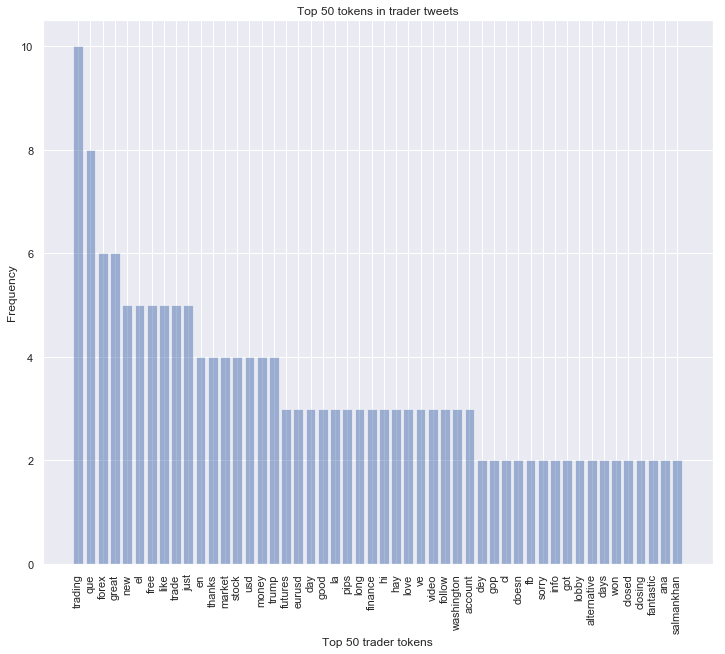

In [51]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='trader', ascending=False)['trader'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='trader', ascending=False)['trader'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 trader tokens')
plt.title('Top 50 tokens in trader tweets');

Even though some of the top 50 tokens can provide some information about the trader tweets, some neutral words such as "like", "just", are one of the most frequent tokens. Even though these are the actual high-frequency words, but it is difficult to say that these words are all important words in trader tweets that characterises the trader class.

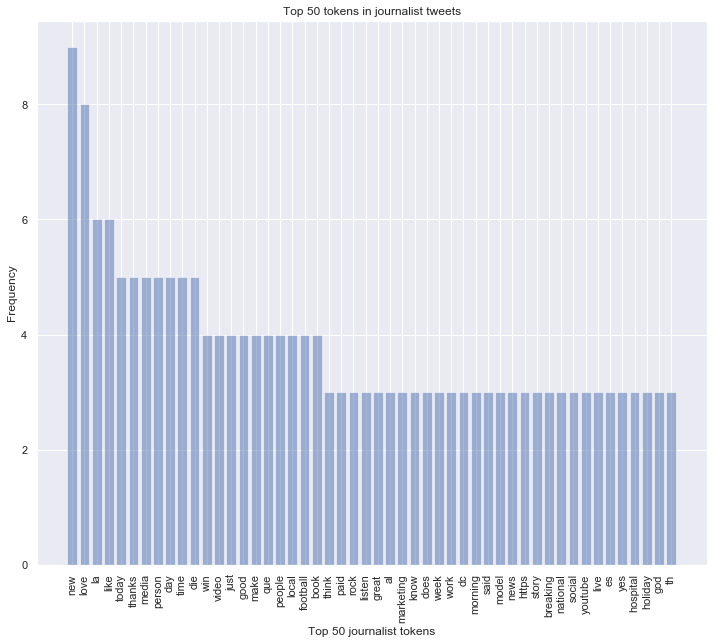

In [52]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='journalist', ascending=False)['journalist'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='journalist', ascending=False)['journalist'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 journalist tokens')
plt.title('Top 50 tokens in journalist tweets');

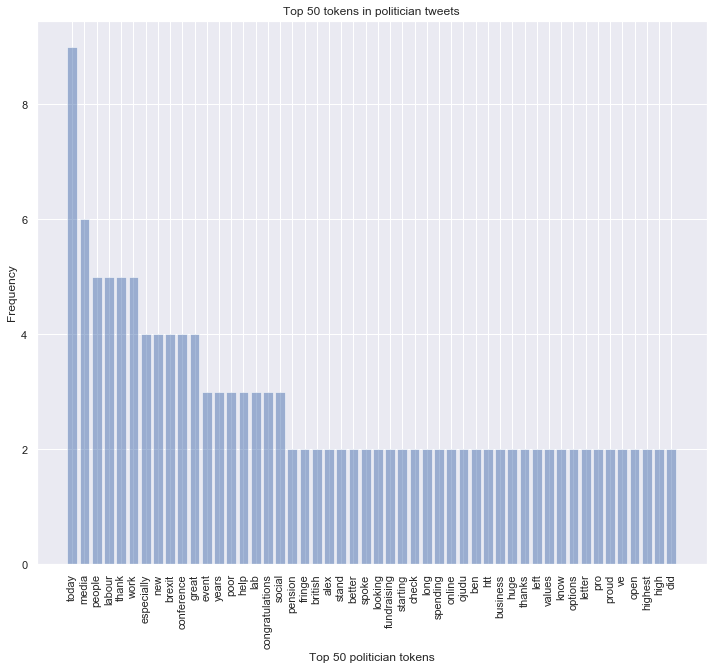

In [53]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='politician', ascending=False)['politician'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='politician', ascending=False)['politician'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 politician tokens')
plt.title('Top 50 tokens in politician tweets');

# 4. Model building (Classification)
I chose to split the data into 2 parts: train, test. 
- Train set: the sample of data for learning.
- Test set: the sample of data used only to testing a model.

The ratio I decided to split is 70/30, 70% of data as the training set and 30% for test set.

In [54]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from time import time

In [55]:
data.head()

,tweet,category,id
0,sodc planning committee tonight at didcot civi...,Politician,4912945864
1,usembassytokyo imamade hontoni arigato gozaima...,Politician,1900694785
2,mrrawle well deserved congratulations,Politician,1887255132
3,people unfollowed me automatically checked by,Politician,1873380343
4,new estimates final tax plan would raise taxes...,Politician,1872999342


In [56]:
data.category.value_counts()

Journalist    224
Trader        144
Politician    113
Name: category, dtype: int64

In [57]:
x = data.tweet
y = data.category

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=102)

In [59]:
print("Train set has total {0} entries with {1:.2f}% Journalist, {2:.2f}% Trader, {3:.2f}% Politician." .format(len(x_train),
                                                                            len(x_train[y_train == 'Journalist']) / (len(x_train)*1.)*100,
                                                                            len(x_train[y_train == 'Trader']) / (len(x_train)*1.)*100,
                                                                            len(x_train[y_train == 'Politician']) / (len(x_train)*1.)*100))
print("\n")
print("Test set has total {0} entries with {1:.2f}% Journalist, {2:.2f}% Trader, {3:.2f}% Politician." .format(len(x_test),
                                                                            len(x_test[y_test == 'Journalist']) / (len(x_test)*1.)*100,
                                                                            len(x_test[y_test == 'Trader']) / (len(x_test)*1.)*100,
                                                                            len(x_test[y_test == 'Politician']) / (len(x_test)*1.)*100))

Train set has total 336 entries with 47.92% Journalist, 28.27% Trader, 23.81% Politician.


Test set has total 145 entries with 43.45% Journalist, 33.79% Trader, 22.76% Politician.


- If we want to use text in machine learning algorithms, we’ll have to convert them to a numerical representation. One of the methods is called __bag-of-words__ approach. The bag of words model ignores grammar and order of words. Once we have a corpus (text data) then first, a list of vocabulary is created based on the entire corpus. Then each document or data entry is represented as numerical vectors based on the vocabulary built from the corpora.
- With `count vectorizer`, we merely count the appearance of the words in each text.
- A model I chose to evaluate different count vectors is the logistic regression. Because of lacking time I have just try some other by default settings (not much meaningful).

Define two functions to iteratively train on the different number of features, then check the accuracy of the logistic regression on the test set.

In [60]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):

    t0 = time()
    model_fit = pipeline.fit(x_train, y_train)
    y_pred = model_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
 
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

I checked the accuracy on validation set for the different number of features by calling the `nfeature_accuracy_checker`

In [61]:
cvec = CountVectorizer()
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
n_features = np.arange(500,3001,500)
    
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Testing result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    return result

Run `nfeature_accuracy_checker` on two different conditions. First with stop words removal, second without stop words removal.

In [62]:
%%time
print("RESULT WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

RESULT WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


Testing result for 500 features
accuracy score: 44.83%
train and test time: 0.04s
--------------------------------------------------------------------------------
Testing result for 1000 features
accuracy score: 50.34%
train and test time: 0.04s
--------------------------------------------------------------------------------
Testing result for 1500 features
accuracy score: 50.34%
train and test time: 0.06s
--------------------------------------------------------------------------------
Testing result for 2000 features
accuracy score: 49.66%
train and test time: 0.05s
--------------------------------------------------------------------------------
Testing result for 2500 features
accuracy score: 4

In [63]:
%%time
print("RESULT WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

RESULT WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


Testing result for 500 features
accuracy score: 48.97%
train and test time: 0.06s
--------------------------------------------------------------------------------
Testing result for 1000 features
accuracy score: 46.90%
train and test time: 0.07s
--------------------------------------------------------------------------------
Testing result for 1500 features
accuracy score: 46.90%
train and test time: 0.08s
--------------------------------------------------------------------------------
Testing result for 2000 features
accuracy score: 48.97%
train and test time: 0.05s
--------------------------------------------------------------------------------
Testing result for 2500 features
accuracy score: 48.2

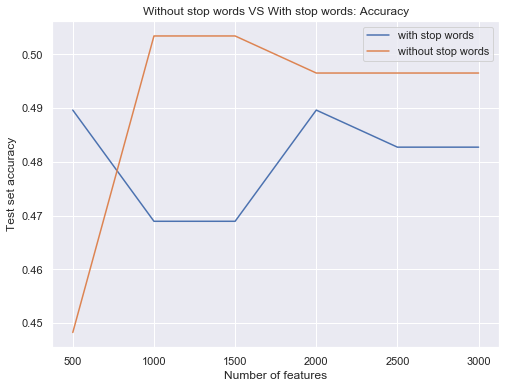

In [64]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','test_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','test_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.test_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.test_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words: Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.legend();

By looking at the test result, removing stop words had improved the model performance. 

- In this assignment, I have looked at how the logistic regression is performing based on the features extracted with count vectorizer.
- There are many algorithms we can try such KNN, random forest, etc. I not going to implement those algorithms.
- There are also many methods for featuring like `Tfidf` vectorizer. I will try to do an experiment if I have a chance.